# Exploration and Exploitation
This lesson introduces the problem of multi-arms bandits: in front of you there are K arms, each one of them giving you a different average rewards. The goal is to maximize your cumulated rewards over a given number of actions (we have a limited budget of actions). The problem is not an easy one to solve as it requires to balance Exploration (ie testing new arms) and Exploitation (ie pulling the arm that gave us the biggest amount of rewards)

In this case there are only action, not states:

The action value function is defined by:
$$
Q(a) = \mathbb E [r|a]
$$

There are different approaches:
* A greedy policy that acts greedly with respect to the first estimation it has
* An $\epsilon$-greedy one that work well in practice
* An Upper Confidence Bound approach that uses uncertainty over the action
* Bayesian approaches
* ...

To illustrate the lesson I implemented some of the algorithms to check their efficiency on the k armed bandit



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

#simple implementation of a K armed bandit
class KArmedBandits():
    """
    The rewards are sampled around k means, with variance 1
    """
    def __init__(self,K):
        self.means = np.random.randn(K)

    def step(self,action):
        #sampling the arm as presented in Sutton and Barto
        return np.random.randn(1)+ self.means[action]

Here are my implementations of different agents: a random agent, an epsilon greedy and a UCB Agent

In [2]:
class RandomAgent():
    """
    Random agent that counts average reward
    """
    def __init__(self,nb_actions):
        self.means = np.zeros(nb_actions)
        self.nb_actions = nb_actions
        self.count = np.zeros(nb_actions)

    def sample(self):
        return random.randint(0,self.nb_actions-1)

    #function to update the running mean (using exact mean iteration)
    def update(self,action,reward):
        self.count[action] += 1
        self.means[action] += (reward-self.means[action])/self.count[action]

class EpsilonGreedyAgent(RandomAgent):
    """
    Agent that act in a epsilon greedy manner given the possible arms it can pull
    epsilon is for the developer to choose (to decay if need be):
    with probability epsilon the agent picks a random action
    ortherwise it acts greedily
    """
    def __init__(self,nb_actions,eps):
        
        RandomAgent.__init__(self,nb_actions)
        self.eps = eps


    #function to samplle an action
    def sample(self):
        if random.random()<self.eps:
            #making random action
            return random.randint(0,self.nb_actions-1)
        else:
            #greedy action
            return np.argmax(self.means)



class UCBAgent(EpsilonGreedyAgent):
    """
    UCB: Upper Confidence Bound Action selection, it gives more probability to the actions that were not tried
    allows for a better assessment of the mean
    """
    def __init__(self,K,c):

        EpsilonGreedyAgent.__init__(self,K,0.)
        self.time=1
        self.c= c
    def sample(self):
        if np.min(self.count)==0:
            action = np.argmin(self.count)
        else:
            action = np.argmax(self.means + self.c*np.sqrt(np.log(self.time))/np.sqrt(self.count))
        self.time +=1
        return action

In [11]:
#main greedy function to run the different trials
def main(agent,arms,steps,verbose=True):
    bandits = KArmedBandits(arms)
    


    for step in range(steps):
        action=agent.sample()
        reward = bandits.step(action)
        agent.update(action,reward)

    print(bandits.means)
    print(agent.means)

We test here the random agent

In [13]:
arms =10
agent = RandomAgent(arms)
main(agent,arms,4000)

[ 1.22574894  0.91920576 -0.2077521  -0.32246061 -0.39641322 -1.23918354
 -1.34093399  1.52598878  0.23265045  0.61056301]
[ 1.25843229  0.89478761 -0.19424825 -0.31910537 -0.38927863 -1.21143578
 -1.37429135  1.56432897  0.18157574  0.57592104]


The random agent has a good estimation of all the means, but a really low score

Here we test the epsilon greedy one

In [14]:
epsilon=0.1
agent = EpsilonGreedyAgent(arms,epsilon)
main(agent,arms,4000)

[-0.51730572  0.37154545 -0.39911299 -0.84511884  1.04400869 -1.04475833
 -0.89749156 -0.04819062  0.34861529 -0.11225816]
[-0.53485172  0.5480335  -0.49511801 -0.87419065  1.02238076 -0.89983666
 -1.1267871  -0.09158291  0.52096852  0.04416127]


The epsilon greedy has a really good knowledge of the best reward

In [15]:
agent = UCBAgent(arms,2)
main(agent,arms,4000)

[-0.13705215 -0.41300571 -0.67187984  0.09987795  1.43671164  1.16130665
 -0.15717687 -0.48598118  0.87720131 -1.11577792]
[-0.0236104  -0.76384422 -1.16486263 -0.04001564  1.42480492  1.1045898
 -0.2581035  -0.37309567  0.29781207 -0.68885994]


We will now assess the percentage of optimal actions that these agent do with N tests

In [18]:
#iterator to get the data about the trials
def main_greedy_plots(arms,steps,agent_cls,verbose=True,**kwargs):
    bandits = KArmedBandits(arms)
    eps_agent = agent_cls(**kwargs)
    #for plots
    number_of_optimal_actions=0
    rewards=[]
    #classic loop of action/reaction
    for step in range(steps):
        action=eps_agent.sample()
        reward = bandits.step(action)
        eps_agent.update(action,reward)
        if action == np.argmax(bandits.means):
            number_of_optimal_actions+=1
        #for plots
        
        yield np.mean(reward)/np.max(bandits.means),number_of_optimal_actions/(step+1)
    if verbose:
        print(bandits.means)
        print(eps_agent.means)

#function to create plots about the choices of the algorti
def trials(nb_trials,agent_cls,**kwargs):
    arms = 10
    steps = 1000
    total_rws = []
    total_bests=[]
    for k in range(nb_trials):
        av_rws,av_bests = zip(*[(av_rw,av_best) for (av_rw,av_best) in main_greedy_plots(arms,steps,agent_cls,verbose=False,**kwargs)])
        total_rws.append(av_rws)
        total_bests.append(av_bests)
    total_rws = np.array(total_rws)
    total_bests = np.array(total_bests)
    plt.plot(total_rws.mean(0))
    plt.title("Average reward received")
    plt.figure()
    plt.plot(total_bests.mean(0))
    plt.title("Percentage of optimal actions")
    plt.show()

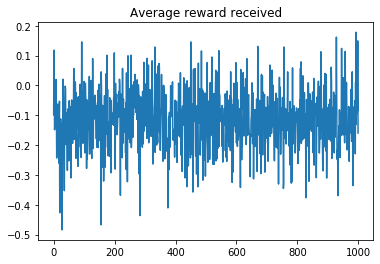

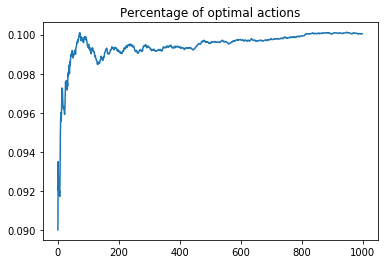

In [19]:
trials(1000,RandomAgent,nb_actions=10)

The random agent converges to 1/N probability of pulling the right arm

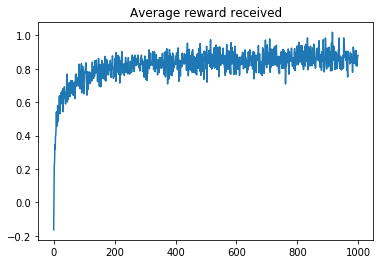

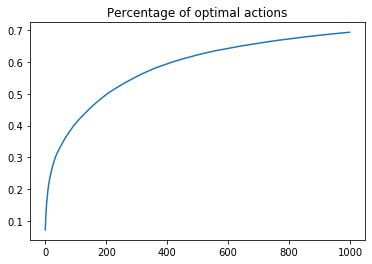

In [21]:
trials(1000,EpsilonGreedyAgent,nb_actions=10,eps=0.1)

The epsilon greedy agent converges much more stably towards the best arm but it will always be limited by its 10% of exploration (of course we could improve this simple agent by making a decaying epsilon)

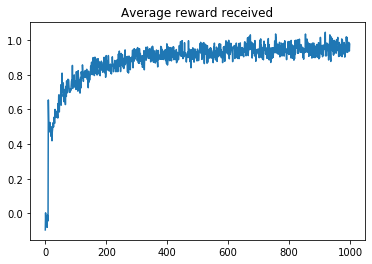

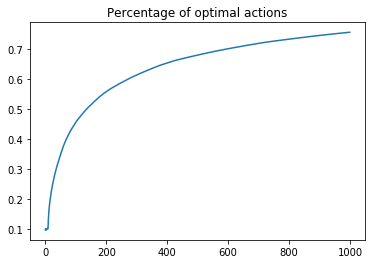

In [23]:
trials(1000,UCBAgent,K=10,c=2)


The UCB Agent is the one that has the highest percentage of optimal actions